In [1]:
import math
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import random

# Import data

In [2]:
ac_path = r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Action'
os.chdir(ac_path)
all_file = os.listdir(ac_path)

all_action = []
for i in range(len(all_file)):
    p = list(pd.read_csv(all_file[i])['0'])
    all_action.append(p)
Merge_action = list(itertools.chain(*all_action))
Unique_action = set(Merge_action)
process = list(Unique_action)

In [5]:
process
state_process = [sub.replace('Add','Formulation') for sub in process]
state_process

['Show', 'Edit', 'Remove', 'Analysis', 'Formulation', 'Cost']

In [19]:
def first_order(df):
    Freq_count_1=pd.DataFrame(0,columns=process,index=process)
    Trans_prob_1=pd.DataFrame(0,columns=process,index=process)
    for i in range(len(process)):
        for j in range(len(process)):
            for k in range(len(df)-1):
                if((process[i]+ process[j])==(df['0'][k]+df['0'][k+1])):
                    Freq_count_1.iloc[i,j] +=1
    for i in range(len(Trans_prob_1)):
        Trans_prob_1.iloc[i,:]= Freq_count_1.iloc[i,:]/Freq_count_1.iloc[i,:].sum()
    Trans_prob_1=Trans_prob_1.fillna(0)
    return Trans_prob_1

In [20]:
def state_location(unique_actions):
    dic = {j:i for i,j in enumerate(unique_actions)}
    return dic
location_to_states = state_location(state_process)
actions = [0,1,2,3,4,5]

state_to_location = dict((state,location) for location, state in location_to_states.items())
location_to_states

{'Show': 0, 'Edit': 1, 'Remove': 2, 'Analysis': 3, 'Formulation': 4, 'Cost': 5}

In [21]:
def Q_table(end_location,reward,alpha = 0.1,gamma = 0.3,iteration=10000):
    reward_copy = np.copy(reward)
    ending_state = location_to_states[end_location]
    Q = np.array(np.zeros([6,6]))
    for i in range(iteration):
        current_state = np.random.randint(0,6)
        playable_actions = []
        for j in range(6):
            if reward_copy[current_state,j]>=0:
                playable_actions.append(j)
        next_state = np.random.choice(playable_actions)
        TD = reward_copy[current_state,next_state] + gamma * Q [next_state, np.argmax(Q[next_state,])] - Q[current_state, next_state]
        Q[current_state,next_state] += alpha * TD
    return Q

In [9]:
# Probability function
def prob(theta,Q):
    a = np.exp(theta * Q)
    return a / a.sum(axis= 0)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def accuracy(pred,actual):
    loss = sum([x != y for x, y in zip(pred, actual)])
    acc = 1 - loss/len(pred)
    return acc

In [66]:
def sequence_generator(df,Q,start_theta=1,end_theta=10,iteration = 50,max = False):
#    sequences = []
#    for l in range(len(df)):
#        seq = pd.read_csv(file[l])['0']
    seq = df['0']
    seq = [sub.replace('Add','Formulation') for sub in seq]
    total_route = []
    for j in np.arange(start_theta,end_theta,1):
        route_50 = []
        for k in range(iteration):
            start_action = seq[0]
            route = [start_action]
            #    next_action = start_action
            for i in range(len(seq)-1):
                starting_state = location_to_states[start_action]
                if max == False:
                    next_state = random.choices(np.arange(0,6),(prob(j,Q[starting_state,])))[0]
                else:
                    next_state = np.argmax(Q[starting_state,])
                next_action = state_to_location[next_state]
                route.append(next_action)
                route = [sub.replace('Formulation','Add') for sub in route]
                start_action = seq[i + 1]
            route_50.append(route)
        total_route.append(route_50)
#        sequences.append(total_route)
    return total_route

In [67]:
def accuracy_generator(df,sequence):
    all_accs = []
    for ac in range(len(sequence)):
#        actual = pd.read_csv(file[ac])['0']
        actual = df['0']
        actual = [sub.replace('Add','Formulation') for sub in actual]
        pred = sequence[ac]
        total_accs = []
        for i in range(len(pred)):
            acc = accuracy(pred[i],actual)
#            temp_acc.append(acc)
                #avg = np.average(temp_acc)
            total_accs.append(acc)
        all_accs.append(total_accs)
    return all_accs

In [86]:
actual = test['0']
actual = [sub.replace('Add','Formulation') for sub in actual]
pred = sequences[0]
total_accs = []
for i in range(len(pred)):
    acc = accuracy(pred[i],actual)
#    temp_acc.append(acc)
    #avg = np.average(temp_acc)
    total_accs.append(acc)

In [87]:
len(total_accs)

50

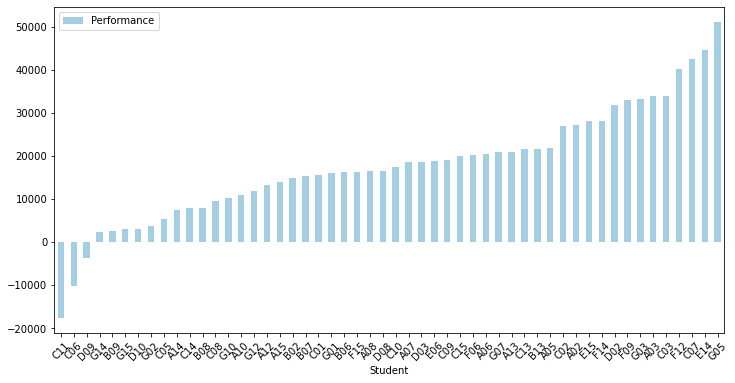

In [12]:
performace = pd.read_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\performance.csv',index_col=None)
h_perform = performace.sort_values('Weighted ANE')
h_perform.plot.bar(x = 'Student',y='Weighted ANE',rot = 45,figsize = (12,6),colormap='Paired')
plt.legend(["Performance"])

In [26]:
high_perform_10 = list(h_perform['Student'])[-10:]
low_perform_10 = list(h_perform['Student'])[:10]
high_file = [i +'.csv' for i in high_perform_10]
low_file = [i + '.csv' for i in low_perform_10]

In [68]:
Q_T10_mean = []
Q_T10_std = []
for file in high_file:
    a = pd.read_csv(file)
    size = math.ceil(len(a) * 0.7)
    train = a.loc[:size]
    test = a.loc[size:].reset_index(drop= True)
    reward = first_order(train)
    Q = Q_table('Analysis',reward)
    sequences = sequence_generator(test,Q,max= False)
    all_accs = accuracy_generator(test, sequences)
    mean_accs = np.mean(all_accs[-1])
    mean_std = np.std(all_accs[-1])
    Q_T10_mean.append(mean_accs)
    Q_T10_std.append(mean_std)
    print('Accuracy of {} is: {}'.format(file,mean_accs))

Accuracy of F14.csv is: 0.6454135338345866
Accuracy of D02.csv is: 0.6497029702970297
Accuracy of F09.csv is: 0.3787341772151899
Accuracy of G03.csv is: 0.22555555555555554
Accuracy of A03.csv is: 0.4248979591836735
Accuracy of C03.csv is: 0.5373469387755101
Accuracy of F12.csv is: 0.2758024691358025
Accuracy of C07.csv is: 0.47505376344086025
Accuracy of E14.csv is: 0.3075
Accuracy of G05.csv is: 0.6267326732673267


In [ ]:
### Debug Start

In [25]:
file

'G05.csv'

In [40]:
reward

,Show,Edit,Remove,Analysis,Add,Cost
Show,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000
Edit,0.005319,0.840426,0.021277,0.010638,0.085106,0.037234
Remove,0.000000,0.500000,0.333333,0.000000,0.166667,0.000000
Analysis,0.125000,0.875000,0.000000,0.000000,0.000000,0.000000
Add,0.000000,0.708333,0.000000,0.000000,0.250000,0.041667
Cost,0.000000,0.375000,0.000000,0.625000,0.000000,0.000000


In [41]:
col_prob = np.array(reward.loc[test['0'][1]]).tolist()
print(col_prob)

[0.0, 0.375, 0.0, 0.625, 0.0, 0.0]


In [32]:
Q

array([[0.54449974, 0.6935157 , 0.25805471, 0.70388804, 0.32055471,
        0.29866641],
       [0.21648556, 1.2006079 , 0.2793313 , 0.38119301, 0.40566109,
        0.33590045],
       [0.21116641, 0.86018237, 0.59138804, 0.37055471, 0.48722138,
        0.29866641],
       [0.33616641, 1.23518237, 0.25805471, 0.37055471, 0.32055471,
        0.29866641],
       [0.21116641, 1.0685157 , 0.25805471, 0.37055471, 0.57055471,
        0.34033308],
       [0.21116641, 0.73518237, 0.25805471, 0.99555471, 0.32055471,
        0.29866641]])

In [58]:
prb = prob(5,Q[location_to_states[test['0'][1]],])
print(prb)

[0.01433153 0.19686969 0.01811796 0.72371939 0.02476432 0.02219711]


In [62]:
random.choices(np.arange(0,6),(prb))[0]

3

In [ ]:
### DEBUG END

In [69]:
Q_L10_mean = []
Q_L10_std = []
for file in low_file:
    a = pd.read_csv(file)
    size = math.ceil(len(a) * 0.7)
    train = a.loc[:size]
    test = a.loc[size:].reset_index(drop= True)
    reward = first_order(train)
    Q = Q_table('Analysis',reward)
    sequences = sequence_generator(test,Q,max=True)
    all_accs = accuracy_generator(test, sequences)
    mean_accs = np.mean(all_accs[-1])
    mean_std = np.std(all_accs[-1])
    Q_L10_mean.append(mean_accs)
    Q_L10_std.append(mean_std)
    print('Accuracy of {} is: {}'.format(file,mean_accs))

Accuracy of C11.csv is: 0.5057471264367815
Accuracy of C06.csv is: 0.5
Accuracy of D09.csv is: 0.5333333333333333
Accuracy of G14.csv is: 0.20689655172413793
Accuracy of B09.csv is: 0.171875
Accuracy of G15.csv is: 0.3461538461538462
Accuracy of D10.csv is: 0.19424460431654678
Accuracy of G02.csv is: 0.4624999999999999
Accuracy of C05.csv is: 0.35922330097087374
Accuracy of A14.csv is: 0.7413793103448275


In [70]:
Q_L10_pr = pd.DataFrame(list(zip(low_perform_10,Q_L10_mean)), columns=['Students','MC'])
Q_L10_pr.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\Q_L10_pr.csv')

In [150]:
Q_L10_mx = pd.DataFrame(list(zip(low_perform_10,Q_L10_mean)), columns=['Students','MC'])
Q_L10_mx.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\Q_L10_mx.csv')

In [154]:
Q_T10_mx = pd.DataFrame(list(zip(high_perform_10,Q_T10_mean)), columns=['Students','MC'])
Q_T10_mx.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\Q_T10_mx.csv')

In [71]:
Q_T10_pr = pd.DataFrame(list(zip(high_perform_10,Q_T10_mean)), columns=['Students','MC'])
Q_T10_pr.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\Q_T10_pr.csv')